# **Importing Libraries**

In [ ]:
import os
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
import torch.nn.functional as F


**Importing Dataset From Kaggle**




In [ ]:
# **Importing Dataset From Kaggle**

# Upload kaggle.json
files.upload()

# Setup Kaggle configuration
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install Kaggle API
!pip install -q kaggle

# Download the dataset using Kaggle API
!kaggle datasets download -d alsaniipe/chest-x-ray-image

# Remove the previous dataset directory to avoid extraction conflicts (optional)
!rm -rf chest_xray_dataset

# Extract the dataset, using -o flag to overwrite any existing files
!unzip -o -q chest-x-ray-image.zip -d chest_xray_dataset

# Paths to dataset
train_path = "chest_xray_dataset/Data/train"
test_path = "chest_xray_dataset/Data/test"
classes = ["COVID19", "PNEUMONIA", "NORMAL"]

# Count the number of images in each class
def count_images(dataset_path):
    return {cls: len(os.listdir(os.path.join(dataset_path, cls))) for cls in classes}

# Print the count of images for each class in the train and test datasets
print("Train:", count_images(train_path))
print("Test:", count_images(test_path))


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/alsaniipe/chest-x-ray-image
License(s): apache-2.0
Train: {'COVID19': 460, 'PNEUMONIA': 3418, 'NORMAL': 1266}
Test: {'COVID19': 116, 'PNEUMONIA': 855, 'NORMAL': 317}


** Transforms & Loader**

In [ ]:
# Define image transformations for preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)), #resizing image to 224 x 224 pixels
    transforms.Grayscale(num_output_channels=1),  # convert to GRAY SCALE
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  #  Grayscale normalization
])


In [ ]:
# Step 1: Define the datasets first
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

# Step 2: Handle class imbalance with WeightedRandomSampler
class_weights = torch.FloatTensor([30.0, 3.0, 1.0])  # You can adjust this based on your class distribution
weights = [class_weights[label] for _, label in train_dataset]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)


# Step 3: Define the DataLoaders with the defined samplers and batch sizes
train_loader = DataLoader(train_dataset, batch_size=8, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


**Define pDCOVIDNET**

In [ ]:
class DilatedConvBlock(nn.Module):
    #Define a custom CNN block
    #__init__ method is used to initialize the module’s parameters
    def __init__(self, in_channels, out_channels, dilation):
        super(DilatedConvBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding = dilation, dilation=dilation)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding = dilation, dilation=dilation)
        self.relu2 = nn.ReLU(inplace=True)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    #Forward pass (Conv → ReLU → Conv → ReLU → MaxPool)
    #used to perform the computation that the module represents
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.pool(x)
        return x

#Main model class
class PDCOVIDNet(nn.Module):
    def __init__(self, num_classes=3):
        super(PDCOVIDNet, self).__init__()

        # Branch 1  Standard convolution path (dilation=1)
        self.branch1 = nn.Sequential(
            DilatedConvBlock(1, 64, dilation=1),
            DilatedConvBlock(64, 128, dilation=1),
            DilatedConvBlock(128, 256, dilation=1),
            DilatedConvBlock(256, 512, dilation=1),
            DilatedConvBlock(512, 512, dilation=1),
        )

        # Branch 2  Dilated convolution path (dilation=2)
        self.branch2 = nn.Sequential(
            DilatedConvBlock(1, 64, dilation=2),
            DilatedConvBlock(64, 128, dilation=2),
            DilatedConvBlock(128, 256, dilation=2),
            DilatedConvBlock(256, 512, dilation=2),
            DilatedConvBlock(512, 512, dilation=2),
        )

        # Fusion layer to combine features from both branches
        self.conv_fuse = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(512 * 7 * 7, 1024) #nn.Linear(num_inputs, hidden_size)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 1024)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(1024, num_classes)

    #mainly starts from here
    def forward(self, x):
        out1 = self.branch1(x)
        out2 = self.branch2(x)

        # Element-wise addition
        out = out1 + out2 #generates the same shape after addition

        # Additional Conv layer after fusion
        out = self.conv_fuse(out)

        # Flatten the previous output that we got after fusion
        out = out.view(out.size(0), -1) #(batch_size, 512 * 7 * 7) = (batch_size, 25088)

        # Fully connected layers (separated operations)
        out = self.fc1(out)          # Linear transformation
        out = F.relu(out)            # ReLU activation
        out = self.dropout1(out)     # Dropout

        out = self.fc2(out)          # Linear transformation
        out = F.relu(out)            # ReLU activation
        out = self.dropout2(out)     # Dropout

        out = self.fc3(out)          # Final linear transformation

        return out  # Let CrossEntropyLoss apply LogSoftmax internally

**Data Augmentation**

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(30),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.15, 0.15),
        scale=(0.9, 1.1),
        shear=10,
        interpolation=transforms.InterpolationMode.NEAREST
    ),
])


** Train the Model**

In [ ]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Model setup
model = PDCOVIDNet(num_classes=3).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)  # Learning rate scheduler

criterion = nn.CrossEntropyLoss()


# Early stopping parameters
best_val_loss = float('inf')
patience = 3  # Number of epochs to wait before stopping
no_improve = 0  # Counter for epochs without improvement

# Training loop with early stopping
import time

# Training loop with time tracking
for epoch in range(20):
    start_time = time.time()  # Start timing

    model.train()
    train_loss = 0.0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

    avg_train_loss = train_loss / total_samples

    # Validation phase (your current code goes here)

    end_time = time.time()
    epoch_duration = end_time - start_time


    print(f"Epoch {epoch+1}: Train Loss = {avg_train_loss:.4f}")


Epoch 1: Train Loss = 0.6445
Epoch 2: Train Loss = 0.2570
Epoch 3: Train Loss = 0.1886
Epoch 4: Train Loss = 0.1628
Epoch 5: Train Loss = 0.1262
Epoch 6: Train Loss = 0.0986
Epoch 7: Train Loss = 0.0800
Epoch 8: Train Loss = 0.0978
Epoch 9: Train Loss = 0.0708
Epoch 10: Train Loss = 0.0636
Epoch 11: Train Loss = 0.0592
Epoch 12: Train Loss = 0.0651
Epoch 13: Train Loss = 0.0500
Epoch 14: Train Loss = 0.0466
Epoch 15: Train Loss = 0.0375
Epoch 16: Train Loss = 0.0560
Epoch 17: Train Loss = 0.0357
Epoch 18: Train Loss = 0.0416
Epoch 19: Train Loss = 0.0381
Epoch 20: Train Loss = 0.0364


**Evalution**

In [ ]:
# **Evaluation**

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


Classification Report

In [ ]:
# Classification Report

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

# Print evaluation metrics
print('Macro Avg. Recall Score:', recall_score(y_true, y_pred, average='macro'))
print('Macro Avg. Precision Score:', precision_score(y_true, y_pred, average='macro'))
print('Macro Avg. F1 Score:', f1_score(y_true, y_pred, average='macro'))
print('Accuracy:', accuracy_score(y_true, y_pred))

print('\nEvaluation Report:')
print(classification_report(y_true, y_pred, target_names=['COVID19', 'PNEUMONIA', 'NORMAL']))





Macro Avg. Recall Score: 0.958499178012595
Macro Avg. Precision Score: 0.9616666752263171
Macro Avg. F1 Score: 0.9600511994320439
Accuracy: 0.9611801242236024

Evaluation Report:
              precision    recall  f1-score   support

     COVID19       0.99      0.97      0.98       116
   PNEUMONIA       0.92      0.93      0.93       317
      NORMAL       0.97      0.97      0.97       855

    accuracy                           0.96      1288
   macro avg       0.96      0.96      0.96      1288
weighted avg       0.96      0.96      0.96      1288



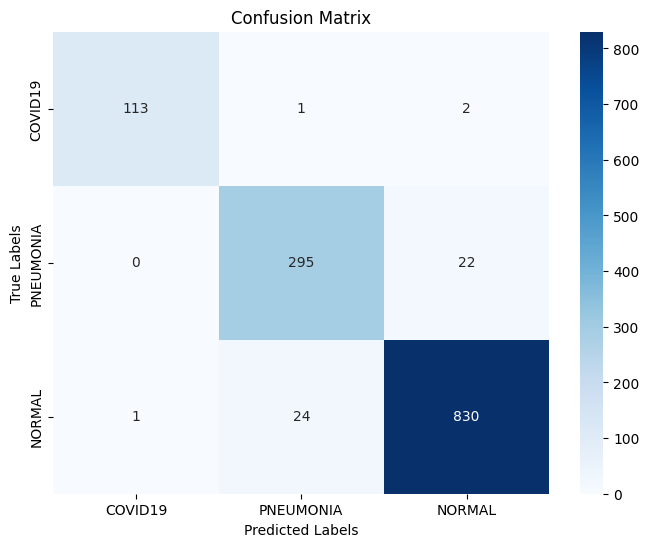

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Set up the figure size
plt.figure(figsize=(8, 6))

# Plot confusion matrix with seaborn heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)

# Labeling the axes
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

# Show the plot
plt.show()
